In [ ]:
import os
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
from keras import layers, Model, optimizers, callbacks
from keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
# set ranodm seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [ ]:
# configure tensorflow for memory efficiency
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPUs configured for memory growth: {len(gpus)} GPU(s)")
  except RuntimeError as e:
    print(e)

GPUs configured for memory growth: 1 GPU(s)


In [ ]:
class SiameseNetworkTrainer:
  def __init__(self, input_shape = (128, 128, 3), embedding_dim = 128):
    self.input_shape = input_shape
    self.embedding_dim = embedding_dim
    self.model = None
    self.base_network = None

  def create_base_network(self, trainable_layers = 4):
    """Create base network with MobilenetV2 backbone optimized for limited data"""
    # load MobilenetV2 with pretrained weights
    base_model = MobileNetV2(
        weights = 'imagenet',
        include_top = False,
        input_shape = self.input_shape,
        alpha = 1.0 # width multiplier
    )

    # freeze most layers, only train the last few
    for layer in base_model.layers[:trainable_layers]:
      layer.trainable = False

    # add custom head optimized for limited data
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    # smaller, more regularized network for limited data
    x = layers.Dense(512, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)

    # x = layers.Dense(256, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(0.4)(x)

    x = layers.Dense(self.embedding_dim, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    # L2 normalize embeddings for better similarity comparison
    embeddings = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis = 1))(x)

    model = Model(inputs = base_model.input, outputs = embeddings)
    return model

  def build_siamese_network(self, trainable_layers = 4):
    """build complete siamese network"""
    self.base_network = self.create_base_network(trainable_layers)

    # define inputs
    input_a = layers.Input(shape = self.input_shape, name = 'input_a')
    input_b = layers.Input(shape = self.input_shape, name = 'input_b')

    # get embeddings
    embedding_a = self.base_network(input_a)
    embedding_b = self.base_network(input_b)

    # calculate L1 distance
    l1_distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([embedding_a, embedding_b])

    # classification head
    x = layers.Dense(128, kernel_regularizer = tf.keras.regularizers.l2(0.001))(l1_distance)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, kernel_regularizer = tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    output = layers.Dense(1, activation = 'sigmoid', name = 'output')(x)

    self.model = Model(inputs = [input_a, input_b], outputs = output)
    return self.model

  def compile_model(self, learning_rate = 0.0001):
    """compile model with appropriate optimizer and loss"""
    optimizer = optimizers.Adam(learning_rate = learning_rate)
    self.model.compile(
        optimizer = optimizer,
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    print("Model compiled successfully")
    print(self.model.summary())

In [ ]:
class DataLoader:
  def __init__(self, input_shape = (128, 128, 3)):
    self.input_shape = input_shape

  def load_images_from_folder(self, folder_path):
    """load all images from a folder"""
    images = []
    valid_extensions = ['.png', '.jpg', '.jpeg', '.jfif']

    if not os.path.exists(folder_path):
      print(f"Warning: Folder not found - {folder_path}")
      return images

    for filename in os.listdir(folder_path):
      if any(filename.lower().endswith(ext) for ext in valid_extensions):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is not None:
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          img = cv2.resize(img, (self.input_shape[0], self.input_shape[1]))
          images.append(img)

    return images

  def load_dataset(self, description_file, mode = 'train'):
    """load dataset from description file"""
    print(f"\nLoading {mode} dataset from: {description_file}")

    # try different encodings
    encodings = ['utf-8', 'utf-16', 'latin-1', 'cp1252', 'iso-8859-1']
    df = None

    for encoding in encodings:
      try:
        df = pd.read_csv(description_file, sep = '\t', encoding = encoding)
        print(f"Successfully loaded file with {encoding} encoding")
        break
      except (UnicodeDecodeError, UnicodeError):
        continue

    if df is None:
      raise ValueError(f"Could not read {description_file} with any known encoding")

    dataset = {}
    total_images = 0

    folder_col = 'train_folder_path' if mode == 'train' else 'test_folder_path'

    for idx, row in tqdm(df.iterrows(), total = len(df), desc = f"Loading {mode} images"):
      person_id = row['peron_id'] if 'peron_id' in row else row['person_id']
      folder_path = row[folder_col]

      images = self.load_images_from_folder(folder_path)
      if len(images) > 0:
        dataset[person_id] = images
        total_images += len(images)

    print(f"{mode.capitalize()} dataset loaded: {len(dataset)} people, {total_images} total images")
    return dataset

  def augment_image(self, image):
    """apply data augmentation to increase dataset size"""
    # random horizontal flip
    if random.random() > 0.5:
      image = cv2.flip(image, 1)

    # random brightness adjustment
    if random.random() > 0.5:
      factor = 0.7 + random.random() * 0.6 # 0.7 to 1.3
      image = np.clip(image * factor, 0, 255).astype(np.uint8)

    # random rotation (small angle)
    if random.random() > 0.5:
      angle = random.uniform(-15, 15)
      h, w = image.shape[:2]
      M = cv2.getRotationMatrix2D((w/2, h/2), angle, 1.0)
      image = cv2.warpAffine(image, M, (w, h))

    # random Gaussian noise
    if random.random() > 0.7:
      noise = np.random.normal(0, 5, image.shape).astype(np.uint8)
      image = np.clip(image + noise, 0, 255).astype(np.uint8)

    return image

  def create_pairs(self, dataset, num_pairs = 5000, augment = True):
    """create training pairs with equal positive and negative samples"""
    pairs = []
    labels = []

    person_ids = list(dataset.keys())
    num_positive = num_pairs // 2
    num_negative = num_pairs - num_positive

    print(f"\nCreating {num_pairs} pairs ({num_positive} positive pairs, {num_negative} negative pairs)")

    # create positive pairs (same person)
    for _ in tqdm(range(num_positive), desc = "Creating positive pairs"):
      person_id = random.choice(person_ids)
      if len(dataset[person_id]) < 2:
        # if only one image, use augmentation
        img = dataset[person_id][0]
        img1 = self.augment_image(img.copy()) if augment else img
        img2 = self.augment_image(img.copy()) if augment else img
      else:
        img1, img2 = random.sample(dataset[person_id], 2)
        if augment:
          img1 = self.augment_image(img1.copy())
          img2 = self.augment_image(img2.copy())

      pairs.append([img1, img2])
      labels.append(1)

    # create negative pairs (different people)
    for _ in tqdm(range(num_negative), desc = "Creating negative pairs"):
      person1, person2 = random.sample(person_ids, 2)
      img1 = random.choice(dataset[person1])
      img2 = random.choice(dataset[person2])

      if augment:
        img1 = self.augment_image(img1.copy())
        img2 = self.augment_image(img2.copy())

      pairs.append([img1, img2])
      labels.append(0)

    return np.array(pairs), np.array(labels)

  def preprocess_pairs(self, pairs):
    """normalize pairs for training"""
    pairs = pairs.astype('float32') / 255.0
    return pairs

In [ ]:
class Evaluator:
  def __init__(self, model):
    self.model = model

  def evaluate(self, test_pairs, test_labels, phase_name = 'Test'):
    """evaluate model and return all metrics"""
    print(f"\n{'='*70}")
    print(f"{phase_name} Evaluation")
    print(f"{'='*70}")

    # get prediction in smaller batches to avoid memory issues
    print("Generating predictions ...")
    batch_size = 32
    num_samples = len(test_pairs)
    y_pred_probs = []

    for i in range(0, num_samples, batch_size):
      batch_end = min(i + batch_size, num_samples)
      batch_preds = self.model.predict(
          [test_pairs[i:batch_end, 0], test_pairs[i:batch_end, 1]],
           verbose = 0
      )
      y_pred_probs.extend(batch_preds.flatten())

      if i % 320 == 0: # print progress every 10 batches
        print(f"  Progress: {batch_end}/{num_samples} samples")

    y_pred_probs = np.array(y_pred_probs)
    y_pred = (y_pred_probs > 0.5).astype(int)
    y_true = test_labels

    # calculare metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_probs)

    # print metrics
    print(f"\n{phase_name} Metrics:")
    print(f"  Accuracy:   {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  F1-Score:   {f1:.4f}")
    print(f"  AUC-ROC:    {auc_roc:.4f}")

    # store results
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc_roc,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs
    }

    # clear memory
    gc.collect()

    return results

  def plot_confusion_matrix(self, y_true, y_pred, phase_name = 'Test', save_path = None):
    """plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues',
                xticklabels = ['Different', 'Same'],
                yticklabels = ['Different', 'Same'])
    plt.title(f'Confusion Matrix - {phase_name}', fontsize = 14, fontweight = 'bold')
    plt.ylabel('True Label', fontsize = 12)
    plt.xlabel('Predicted Label', fontsize = 12)
    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
      print(f"Confusion matrix saved: {save_path}")

    return cm

  def plot_roc_curve(self, y_true, y_pred_probs, phase_name = "Test", save_path = None):
    """plot ROC curve"""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (8, 6))
    plt.plot(fpr, tpr, color = 'darkorange', lw = 2,
             label = f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize = 12)
    plt.ylabel('True Positive Rate', fontsize = 12)
    plt.title(f'ROC Curve - {phase_name}', fontsize = 14, fontweight = 'bold')
    plt.legend(loc = "lower right")
    plt.grid(alpha = 0.3)
    plt.tight_layout()

    if save_path:
      plt.savefig(save_path, dpi = 300, bbox_inches = 'tight')
      print(f"ROC curve saved: {save_path}")

    return fpr, tpr, roc_auc

In [ ]:
class TrainingPipeline:
  def __init__(self, base_data_file, novel_data_file, input_shape = (128, 128, 3)):
    self.base_data_file = base_data_file
    self.novel_data_file = novel_data_file
    self.input_shape = input_shape
    self.trainer = SiameseNetworkTrainer(input_shape = input_shape)
    self.data_loader = DataLoader(input_shape = input_shape)
    self.evaluator = None
    self.history = {'phase1': None, 'phase2': None}
    self.results = {}

  def phase1_training(self, epochs = 50, batch_size = 32, num_pairs = 10000):
    """phase 1: train on base dataset"""
    print("\n" + "="*70)
    print("PHASE 1: Training on Base Dataset")
    print("="*70)

    # load base dataset (train)
    base_train_dataset = self.data_loader.load_dataset(self.base_data_file, mode = 'train')

    # create training pairs with augmentation
    pairs, labels = self.data_loader.create_pairs(base_train_dataset, num_pairs = num_pairs, augment = True)
    pairs = self.data_loader.preprocess_pairs(pairs)

    # split into train and validation
    indices = np.arange(len(pairs))
    train_idx, val_idx = train_test_split(indices, test_size = 0.2, random_state = 42)

    train_pairs = pairs[train_idx]
    train_labels = labels[train_idx]
    val_pairs = pairs[val_idx]
    val_labels = labels[val_idx]

    print(f"\nTraining samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")

    # clear memory before building model
    del pairs, labels, indices, base_train_dataset
    gc.collect()

    # build and compile model
    self.trainer.build_siamese_network(trainable_layers = 3)
    self.trainer.compile_model(learning_rate = 0.0001)

    # callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 10,
        restore_best_weights = True,
        verbose = 1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 5,
        min_lr = 1e-7,
        verbose = 1
    )

    checkpoint = callbacks.ModelCheckpoint(
        'mobilenetv2_phase1_best_weights.h5',
        monitor = 'val_loss',
        save_best_only = True,
        verbose = 1
    )

    # train
    print("\nStarting Phase 1 training ...")
    self.history['phase1'] = self.trainer.model.fit(
        [train_pairs[:, 0], train_pairs[:, 1]],
        train_labels,
        validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [early_stopping, reduce_lr, checkpoint],
        verbose = 1
    )

    # save final model
    self.trainer.model.save_weights('mobilnetv2_phase1_final.weights.h5')
    print("\nPhase 1 training complete")

    # clear memory before evaluation
    del train_pairs, train_labels, val_pairs, val_labels
    gc.collect()

    # evaluate on base test set
    self.evaluate_phase1()

  def evaluate_phase1(self):
    """evaluate phase 1 on base test dataset"""
    print("\n" + "="*70)
    print("PHASE 1: Evaluation on Base Test Dataset")
    print("="*70)

    # load base test dataset
    base_test_dataset = self.data_loader.load_dataset(self.base_data_file, mode = 'test')

    # create test pairs (no augmentation)
    test_pairs, test_labels = self.data_loader.create_pairs(base_test_dataset, num_pairs = 2000, augment = False)
    test_pairs = self.data_loader.preprocess_pairs(test_pairs)

    # clear dataset from memory
    del base_test_dataset
    gc.collect()

    # evaluate
    self.evaluator = Evaluator(self.trainer.model)
    self.results['phase1_base_test'] = self.evaluator.evaluate(test_pairs, test_labels, "Phase 1 = Base Test")

    # plot confusion matrix and ROC curve
    self.evaluator.plot_confusion_matrix(
        self.results['phase1_base_test']['y_true'],
        self.results['phase1_base_test']['y_pred'],
        "Phase 1 - Base Test",
        "mobilenetv2_phase1_base_confusion_matrix.png"
    )
    plt.close() # close to free memory

    self.evaluator.plot_roc_curve(
        self.results['phase1_base_test']['y_true'],
        self.results['phase1_base_test']['y_pred_probs'],
        "Phase 1 - Base Test",
        "mobilenetv2_phase1_base_roc_curve.png"
    )
    plt.close()

    # clear memory
    del test_pairs, test_labels
    gc.collect()

  def phase2_finetuning(self, epochs = 30, batch_size = 16, num_pairs = 5000):
    """phase 2: Fine-tune on novel dataset"""
    print("\n" + "="*70)
    print("PHASE 2: Fine-tuning on Novel dataset")
    print("="*70)

    # load best model from phase 1
    print("\nLoading Phase 1 best model ...")
    self.trainer.model.load_weights('mobilenetv2_phase1_best_weights.h5')

    # unfreeze more layers for fine-tuning
    print("Freezing more layers for fine-tuning ...")
    for layer in self.trainer.base_network.layers[:-4]:
      layer.trainable = False

    # recompile with lower learning rate
    self.trainer.compile_model(learning_rate = 0.00001)

    # load novel train dataset
    novel_train_dataset = self.data_loader.load_dataset(self.novel_data_file, mode = 'train')

    # create training pairs with heavy augmentation (limited data)
    pairs, labels = self.data_loader.create_pairs(novel_train_dataset, num_pairs = num_pairs, augment = True)
    pairs = self.data_loader.preprocess_pairs(pairs)

    # split into train and validation
    indices = np.arange(len(pairs))
    train_idx, val_idx = train_test_split(indices, test_size = 0.2, random_state = 42)

    train_pairs = pairs[train_idx]
    train_labels = labels[train_idx]
    val_pairs = pairs[val_idx]
    val_labels = labels[val_idx]

    print(f"\nTraining samples: {len(train_pairs)}")
    print(f"Validation samples: {len(val_pairs)}")

    # callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 8,
        restore_best_weights = True,
        verbose = 1
    )

    reduce_lr = callbacks.ReduceLROnPlateau(
        monitor = 'val_loss',
        factor = 0.5,
        patience = 4,
        min_lr = 1e-8,
        verbose = 1
    )

    checkpoint = callbacks.ModelCheckpoint(
        'mobilenetv2_phase2_best.weights.h5',
        monitor = 'val_loss',
        save_best_only = True,
        save_weights_only = True,
        verbose = 1
    )

    # fine-tune
    print("\nStarting Phase 2 fine-tuning ...")
    self.history['phase2'] = self.trainer.model.fit(
        [train_pairs[:, 0], train_pairs[:, 1]],
        train_labels,
        validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels),
        batch_size = batch_size,
        epochs = epochs,
        callbacks = [early_stopping, reduce_lr, checkpoint],
        verbose = 1
    )

    # save final model
    self.trainer.model.save_weights('mobilenetv2_final_model.weights.h5')
    print("\nPhase 2 fine-tuning complete")

    # evaluate on novel test set
    self.evaluate_phase2()

  def evaluate_phase2(self):
    """evaluate phase 2 on novel test dataset"""
    self.evaluator = Evaluator(self.trainer.model)

    print("\n" + "="*70)
    print("PHASE 2: Evaluation on Novel Test Dataset")
    print("="*70)

    novel_test_dataset = self.data_loader.load_dataset(self.novel_data_file, mode = 'test')
    test_pairs, test_labels = self.data_loader.create_pairs(novel_test_dataset, num_pairs = 2000, augment = False)
    test_pairs = self.data_loader.preprocess_pairs(test_pairs)
    del novel_test_dataset
    gc.collect()

    self.results['phase2_novel_test'] = self.evaluator.evaluate(test_pairs, test_labels, "Phase 2 - Novel Test")

    self.evaluator.plot_confusion_matrix(
        self.results['phase2_novel_test']['y_true'],
        self.results['phase2_novel_test']['y_pred'],
        "Phase 2 - Novel Test",
        "mobilenetv2_phase2_novel_confusion_matrix.png"
    )
    plt.close()

    self.evaluator.plot_roc_curve(
            self.results['phase2_novel_test']['y_true'],
            self.results['phase2_novel_test']['y_pred_probs'],
            "Phase 2 - Novel Test",
            "mobilenetv2_novel_roc_curve.png"
    )
    plt.close()

    del test_pairs, test_labels
    gc.collect()

  def plot_training_history(self):
    """plot training history for both phases"""
    fig, axes = plt.subplots(2, 2, figsize = (15, 10))

    # phase 1
    if self.history['phase1']:
      h1 = self.history['phase1']

      # loss
      axes[0, 0].plot(h1.history['loss'], label='Train Loss', linewidth=2)
      axes[0, 0].plot(h1.history['val_loss'], label='Val Loss', linewidth=2)
      axes[0, 0].set_title('Phase 1: Loss', fontsize=14, fontweight='bold')
      axes[0, 0].set_xlabel('Epoch')
      axes[0, 0].set_ylabel('Loss')
      axes[0, 0].legend()
      axes[0, 0].grid(True, alpha=0.3)

      # accuracy
      axes[0, 1].plot(h1.history['accuracy'], label='Train Accuracy', linewidth=2)
      axes[0, 1].plot(h1.history['val_accuracy'], label='Val Accuracy', linewidth=2)
      axes[0, 1].set_title('Phase 1: Accuracy', fontsize=14, fontweight='bold')
      axes[0, 1].set_xlabel('Epoch')
      axes[0, 1].set_ylabel('Accuracy')
      axes[0, 1].legend()
      axes[0, 1].grid(True, alpha=0.3)

    # phase 2
    if self.history['phase2']:
      h2 = self.history['phase2']

      # loss
      axes[1, 0].plot(h2.history['loss'], label='Train Loss', linewidth=2)
      axes[1, 0].plot(h2.history['val_loss'], label='Val Loss', linewidth=2)
      axes[1, 0].set_title('Phase 2: Loss (Fine-tuning)', fontsize=14, fontweight='bold')
      axes[1, 0].set_xlabel('Epoch')
      axes[1, 0].set_ylabel('Loss')
      axes[1, 0].legend()
      axes[1, 0].grid(True, alpha=0.3)

      # accuracy
      axes[1, 1].plot(h2.history['accuracy'], label='Train Accuracy', linewidth=2)
      axes[1, 1].plot(h2.history['val_accuracy'], label='Val Accuracy', linewidth=2)
      axes[1, 1].set_title('Phase 2: Accuracy (Fine-tuning)', fontsize=14, fontweight='bold')
      axes[1, 1].set_xlabel('Epoch')
      axes[1, 1].set_ylabel('Accuracy')
      axes[1, 1].legend()
      axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('mobilenetv2_training_history.png', dpi = 300, bbox_inches = 'tight')
    print("\nTraining history plot saved: mobilenetv2_training_history.png")
    plt.show()

  def save_results_summary(self):
    """save all results to a text file"""
    with open('mobilenetv2_evaluation_results.txt', 'w') as f:
      f.write("="*70 + "\n")
      f.write("MOBILENETV2 EVALUATION RESULTS\n")
      f.write("="*70 + "\n\n")

      for phase_name, results in self.results.items():
        f.write(f"{phase_name.replace('_', ' ').title()}:\n")
        f.write(f"  Accuracy:  {results['accuracy']:.4f} ({results['accuracy']*100:.2f}%)\n")
        f.write(f"  Precision: {results['precision']:.4f}\n")
        f.write(f"  Recall:    {results['recall']:.4f}\n")
        f.write(f"  F1-Score:  {results['f1_score']:.4f}\n")
        f.write(f"  AUC-ROC:   {results['auc_roc']:.4f}\n")
        f.write("\n")

    print("Results summary saved: mobilenetv2_evaluation_results.txt")

In [ ]:
def main():
  """main training function"""
  # configuration
  BASE_DATA_FILE = '/content/drive/MyDrive/ĐATN/base_dataset_description.txt'
  NOVEL_DATA_FILE = '/content/drive/MyDrive/ĐATN/novel_dataset_description.txt'
  INPUT_SHAPE = (128, 128, 3)

  # phase 1 hyperparameters
  PHASE1_EPOCHS = 50
  PHASE1_BATCH_SIZE = 32
  PHASE1_NUM_PAIRS = 10000

  # phase 2 hyperparameters
  PHASE2_EPOCHS = 30
  PHASE2_BATCH_SIZE = 16
  PHASE2_NUM_PAIRS = 5000

  print("="*70)
  print("MOBILENETV2 TRAINING - TWO-PHASE APPROACH WITH EVALUATION")
  print("="*70)

  # initialize pipeline
  pipeline = TrainingPipeline(BASE_DATA_FILE, NOVEL_DATA_FILE, INPUT_SHAPE)

  # run training
  try:
    # phase 1: base training
    pipeline.phase1_training(
        epochs = PHASE1_EPOCHS,
        batch_size = PHASE1_BATCH_SIZE,
        num_pairs = PHASE1_NUM_PAIRS
    )

    # phase 2: fine-tuning
    pipeline.phase2_finetuning(
        epochs = PHASE2_EPOCHS,
        batch_size = PHASE2_BATCH_SIZE,
        num_pairs = PHASE2_NUM_PAIRS
    )

    # plot results
    pipeline.plot_training_history()

    # save summary
    pipeline.save_results_summary()

    print("\n" + "="*70)
    print("TRAINING AND EVALUATION COMPLETE!")
    print("="*70)
    print("\nGenerated files:")
    print("  Models:")
    print("    - mobilenetv2_phase1_best.weights.h5 (best model from phase 1)")
    print("    - mobilenetv2_phase1_final.weights.h5 (final model from phase 1)")
    print("    - mobilenetv2_phase2_best.weights.h5 (best model from phase 2)")
    print("    - mobilenetv2_final_model.weights.h5 (final fine-tuned model)")
    print("\n  Visualizations:")
    print("    - mobilenetv2_training_history.png (training curves)")
    print("    - mobilenetv2_phase1_base_confusion_matrix.png")
    print("    - mobilenetv2_phase1_base_roc_curve.png")
    print("    - mobilenetv2_phase2_base_confusion_matrix.png")
    print("    - mobilenetv2_phase2_base_roc_curve.png")
    print("    - mobilenetv2_phase2_novel_confusion_matrix.png")
    print("    - mobilenetv2_phase2_novel_roc_curve.png")
    print("\n  Results:")
    print("    - mobilenetv2_evaluation_results.txt (all metrics summary)")

  except Exception as e:
    print(f"\nError during training: {e}")
    import traceback
    traceback.print_exc()

MOBILENETV2 TRAINING - TWO-PHASE APPROACH WITH EVALUATION

PHASE 1: Training on Base Dataset

Loading train dataset from: /content/drive/MyDrive/ĐATN/base_dataset_description.txt
Successfully loaded file with utf-16 encoding


Loading train images: 100%|██████████| 21/21 [01:55<00:00,  5.50s/it]


Train dataset loaded: 21 people, 142 total images

Creating 10000 pairs (5000 positive pairs, 5000 negative pairs)


Creating negative pairs: 100%|██████████| 5000/5000 [00:06<00:00, 777.08it/s]



Training samples: 8000
Validation samples: 2000
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model compiled successfully


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  2,982,080 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ activation_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,007,681 (11.47 MB)

 Trainable params: 2,970,977 (11.33 MB)

 Non-trainable params: 36,704 (143.38 KB)

None

Starting Phase 1 training ...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4975 - loss: 3.7550
Epoch 1: val_loss improved from inf to 3.61757, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 176ms/step - accuracy: 0.4976 - loss: 3.7549 - val_accuracy: 0.5075 - val_loss: 3.6176 - learning_rate: 1.0000e-04
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5583 - loss: 3.5539
Epoch 2: val_loss improved from 3.61757 to 3.40850, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.5583 - loss: 3.5538 - val_accuracy: 0.5905 - val_loss: 3.4085 - learning_rate: 1.0000e-04
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5862 - loss: 3.3860
Epoch 3: val_loss improved from 3.40850 to 3.20255, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.5863 - loss: 3.3858 - val_accuracy: 0.6815 - val_loss: 3.2025 - learning_rate: 1.0000e-04
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6773 - loss: 3.1755
Epoch 4: val_loss improved from 3.20255 to 2.94917, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.6774 - loss: 3.1753 - val_accuracy: 0.7815 - val_loss: 2.9492 - learning_rate: 1.0000e-04
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7675 - loss: 2.9443
Epoch 5: val_loss improved from 2.94917 to 2.68010, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7676 - loss: 2.9440 - val_accuracy: 0.8760 - val_loss: 2.6801 - learning_rate: 1.0000e-04
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8587 - loss: 2.6788
Epoch 6: val_loss improved from 2.68010 to 2.45710, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.8587 - loss: 2.6786 - val_accuracy: 0.9120 - val_loss: 2.4571 - learning_rate: 1.0000e-04
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9058 - loss: 2.4519
Epoch 7: val_loss improved from 2.45710 to 2.25997, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.9058 - loss: 2.4516 - val_accuracy: 0.9485 - val_loss: 2.2600 - learning_rate: 1.0000e-04
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9429 - loss: 2.2513
Epoch 8: val_loss improved from 2.25997 to 2.10754, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9430 - loss: 2.2511 - val_accuracy: 0.9565 - val_loss: 2.1075 - learning_rate: 1.0000e-04
Epoch 9/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9674 - loss: 2.0719
Epoch 9: val_loss improved from 2.10754 to 1.96509, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9674 - loss: 2.0717 - val_accuracy: 0.9620 - val_loss: 1.9651 - learning_rate: 1.0000e-04
Epoch 10/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9787 - loss: 1.9162
Epoch 10: val_loss improved from 1.96509 to 1.82530, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9787 - loss: 1.9160 - val_accuracy: 0.9695 - val_loss: 1.8253 - learning_rate: 1.0000e-04
Epoch 11/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9861 - loss: 1.7677
Epoch 11: val_loss improved from 1.82530 to 1.69344, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - accuracy: 0.9861 - loss: 1.7676 - val_accuracy: 0.9675 - val_loss: 1.6934 - learning_rate: 1.0000e-04
Epoch 12/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9947 - loss: 1.6250
Epoch 12: val_loss improved from 1.69344 to 1.56448, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9947 - loss: 1.6249 - val_accuracy: 0.9720 - val_loss: 1.5645 - learning_rate: 1.0000e-04
Epoch 13/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9958 - loss: 1.4945
Epoch 13: val_loss improved from 1.56448 to 1.43696, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9958 - loss: 1.4944 - val_accuracy: 0.9745 - val_loss: 1.4370 - learning_rate: 1.0000e-04
Epoch 14/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9988 - loss: 1.3700
Epoch 14: val_loss improved from 1.43696 to 1.31112, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9988 - loss: 1.3698 - val_accuracy: 0.9795 - val_loss: 1.3111 - learning_rate: 1.0000e-04
Epoch 15/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9979 - loss: 1.2493
Epoch 15: val_loss improved from 1.31112 to 1.19441, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9979 - loss: 1.2491 - val_accuracy: 0.9855 - val_loss: 1.1944 - learning_rate: 1.0000e-04
Epoch 16/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9991 - loss: 1.1375
Epoch 16: val_loss improved from 1.19441 to 1.09807, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9991 - loss: 1.1374 - val_accuracy: 0.9780 - val_loss: 1.0981 - learning_rate: 1.0000e-04
Epoch 17/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9954 - loss: 1.0398
Epoch 17: val_loss improved from 1.09807 to 1.00026, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9954 - loss: 1.0397 - val_accuracy: 0.9810 - val_loss: 1.0003 - learning_rate: 1.0000e-04
Epoch 18/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9937 - loss: 0.9543
Epoch 18: val_loss improved from 1.00026 to 0.90793, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9937 - loss: 0.9542 - val_accuracy: 0.9850 - val_loss: 0.9079 - learning_rate: 1.0000e-04
Epoch 19/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9942 - loss: 0.8743
Epoch 19: val_loss improved from 0.90793 to 0.85258, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9942 - loss: 0.8742 - val_accuracy: 0.9805 - val_loss: 0.8526 - learning_rate: 1.0000e-04
Epoch 20/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9874 - loss: 0.8230
Epoch 20: val_loss improved from 0.85258 to 0.78070, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9874 - loss: 0.8229 - val_accuracy: 0.9875 - val_loss: 0.7807 - learning_rate: 1.0000e-04
Epoch 21/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9905 - loss: 0.7587
Epoch 21: val_loss improved from 0.78070 to 0.70838, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9905 - loss: 0.7587 - val_accuracy: 0.9940 - val_loss: 0.7084 - learning_rate: 1.0000e-04
Epoch 22/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9952 - loss: 0.7008
Epoch 22: val_loss improved from 0.70838 to 0.65734, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9952 - loss: 0.7008 - val_accuracy: 0.9965 - val_loss: 0.6573 - learning_rate: 1.0000e-04
Epoch 23/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9974 - loss: 0.6469
Epoch 23: val_loss improved from 0.65734 to 0.60314, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9974 - loss: 0.6468 - val_accuracy: 0.9990 - val_loss: 0.6031 - learning_rate: 1.0000e-04
Epoch 24/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9979 - loss: 0.5971
Epoch 24: val_loss improved from 0.60314 to 0.55572, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9979 - loss: 0.5970 - val_accuracy: 0.9995 - val_loss: 0.5557 - learning_rate: 1.0000e-04
Epoch 25/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9975 - loss: 0.5520
Epoch 25: val_loss improved from 0.55572 to 0.51404, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9975 - loss: 0.5520 - val_accuracy: 0.9985 - val_loss: 0.5140 - learning_rate: 1.0000e-04
Epoch 26/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9991 - loss: 0.5051
Epoch 26: val_loss improved from 0.51404 to 0.47291, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9991 - loss: 0.5051 - val_accuracy: 0.9970 - val_loss: 0.4729 - learning_rate: 1.0000e-04
Epoch 27/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9978 - loss: 0.4638
Epoch 27: val_loss improved from 0.47291 to 0.42958, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.9978 - loss: 0.4637 - val_accuracy: 0.9995 - val_loss: 0.4296 - learning_rate: 1.0000e-04
Epoch 28/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9961 - loss: 0.4306
Epoch 28: val_loss improved from 0.42958 to 0.39963, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9961 - loss: 0.4306 - val_accuracy: 0.9970 - val_loss: 0.3996 - learning_rate: 1.0000e-04
Epoch 29/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9951 - loss: 0.4007
Epoch 29: val_loss improved from 0.39963 to 0.37803, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9951 - loss: 0.4007 - val_accuracy: 0.9960 - val_loss: 0.3780 - learning_rate: 1.0000e-04
Epoch 30/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9922 - loss: 0.3874
Epoch 30: val_loss improved from 0.37803 to 0.35313, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9922 - loss: 0.3874 - val_accuracy: 0.9970 - val_loss: 0.3531 - learning_rate: 1.0000e-04
Epoch 31/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9892 - loss: 0.3705
Epoch 31: val_loss improved from 0.35313 to 0.32694, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.9893 - loss: 0.3704 - val_accuracy: 0.9980 - val_loss: 0.3269 - learning_rate: 1.0000e-04
Epoch 32/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9940 - loss: 0.3340
Epoch 32: val_loss improved from 0.32694 to 0.30106, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.9940 - loss: 0.3339 - val_accuracy: 1.0000 - val_loss: 0.3011 - learning_rate: 1.0000e-04
Epoch 33/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9975 - loss: 0.3042
Epoch 33: val_loss improved from 0.30106 to 0.27898, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9975 - loss: 0.3042 - val_accuracy: 0.9995 - val_loss: 0.2790 - learning_rate: 1.0000e-04
Epoch 34/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.2749
Epoch 34: val_loss improved from 0.27898 to 0.25484, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 1.0000 - loss: 0.2748 - val_accuracy: 1.0000 - val_loss: 0.2548 - learning_rate: 1.0000e-04
Epoch 35/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9997 - loss: 0.2505
Epoch 35: val_loss improved from 0.25484 to 0.23109, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9997 - loss: 0.2504 - val_accuracy: 1.0000 - val_loss: 0.2311 - learning_rate: 1.0000e-04
Epoch 36/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9998 - loss: 0.2263
Epoch 36: val_loss improved from 0.23109 to 0.20737, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9998 - loss: 0.2263 - val_accuracy: 1.0000 - val_loss: 0.2074 - learning_rate: 1.0000e-04
Epoch 37/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9999 - loss: 0.2028
Epoch 37: val_loss improved from 0.20737 to 0.18679, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9999 - loss: 0.2028 - val_accuracy: 0.9990 - val_loss: 0.1868 - learning_rate: 1.0000e-04
Epoch 38/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9937 - loss: 0.2011
Epoch 38: val_loss did not improve from 0.18679
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.9937 - loss: 0.2012 - val_accuracy: 0.9745 - val_loss: 0.2882 - learning_rate: 1.0000e-04
Epoch 39/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9809 - loss: 0.2446
Epoch 39: val_loss improved from 0.18679 to 0.18063, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - accuracy: 0.9809 - loss: 0.2445 - val_accuracy: 0.9990 - val_loss: 0.1806 - learning_rate: 1.0000e-04
Epoch 40/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9965 - loss: 0.1841
Epoch 40: val_loss improved from 0.18063 to 0.16685, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9965 - loss: 0.1841 - val_accuracy: 0.9995 - val_loss: 0.1668 - learning_rate: 1.0000e-04
Epoch 41/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9990 - loss: 0.1669
Epoch 41: val_loss improved from 0.16685 to 0.15427, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9990 - loss: 0.1669 - val_accuracy: 1.0000 - val_loss: 0.1543 - learning_rate: 1.0000e-04
Epoch 42/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.1531
Epoch 42: val_loss improved from 0.15427 to 0.14214, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 1.0000 - loss: 0.1531 - val_accuracy: 1.0000 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 43/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.1402
Epoch 43: val_loss improved from 0.14214 to 0.12984, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 1.0000 - loss: 0.1402 - val_accuracy: 1.0000 - val_loss: 0.1298 - learning_rate: 1.0000e-04
Epoch 44/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.1275
Epoch 44: val_loss improved from 0.12984 to 0.11743, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 101ms/step - accuracy: 1.0000 - loss: 0.1275 - val_accuracy: 1.0000 - val_loss: 0.1174 - learning_rate: 1.0000e-04
Epoch 45/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.1151
Epoch 45: val_loss improved from 0.11743 to 0.10509, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 1.0000 - loss: 0.1150 - val_accuracy: 1.0000 - val_loss: 0.1051 - learning_rate: 1.0000e-04
Epoch 46/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.1026
Epoch 46: val_loss improved from 0.10509 to 0.09292, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 1.0000 - loss: 0.1026 - val_accuracy: 1.0000 - val_loss: 0.0929 - learning_rate: 1.0000e-04
Epoch 47/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0906
Epoch 47: val_loss improved from 0.09292 to 0.08118, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 1.0000 - loss: 0.0906 - val_accuracy: 1.0000 - val_loss: 0.0812 - learning_rate: 1.0000e-04
Epoch 48/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0788
Epoch 48: val_loss improved from 0.08118 to 0.06992, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 1.0000 - loss: 0.0788 - val_accuracy: 1.0000 - val_loss: 0.0699 - learning_rate: 1.0000e-04
Epoch 49/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 0.0677
Epoch 49: val_loss improved from 0.06992 to 0.05937, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 23s 90ms/step - accuracy: 1.0000 - loss: 0.0676 - val_accuracy: 1.0000 - val_loss: 0.0594 - learning_rate: 1.0000e-04
Epoch 50/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0572
Epoch 50: val_loss improved from 0.05937 to 0.04964, saving model to mobilenetv2_phase1_best_weights.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 1.0000 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0496 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 50.

Phase 1 training complete

PHASE 1: Evaluation on Base Test Dataset

Loading test dataset from: /content/drive/MyDrive/ĐATN/base_dataset_description.txt
Successfully loaded file with utf-16 encoding


Loading test images: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Test dataset loaded: 21 people, 29 total images

Creating 2000 pairs (1000 positive pairs, 1000 negative pairs)


Creating negative pairs: 100%|██████████| 1000/1000 [00:00<00:00, 148119.65it/s]



Phase 1 = Base Test Evaluation
Generating predictions ...
  Progress: 32/2000 samples
  Progress: 352/2000 samples
  Progress: 672/2000 samples
  Progress: 992/2000 samples
  Progress: 1312/2000 samples
  Progress: 1632/2000 samples
  Progress: 1952/2000 samples

Phase 1 = Base Test Metrics:
  Accuracy:   0.9430 (94.30%)
  Precision:  0.8977
  Recall:     1.0000
  F1-Score:   0.9461
  AUC-ROC:    0.9919
Confusion matrix saved: mobilenetv2_phase1_base_confusion_matrix.png
ROC curve saved: mobilenetv2_phase1_base_roc_curve.png

PHASE 2: Fine-tuning on Novel dataset

Loading Phase 1 best model ...
Freezing more layers for fine-tuning ...
Model compiled successfully


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_a             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_b             │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  2,982,080 │ input_a[0][0],    │
│ (Functional)        │                   │            │ input_b[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         65 │ activation_2[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,007,681 (11.47 MB)

 Trainable params: 91,137 (356.00 KB)

 Non-trainable params: 2,916,544 (11.13 MB)

None

Loading train dataset from: /content/drive/MyDrive/ĐATN/novel_dataset_description.txt
Successfully loaded file with utf-8 encoding


Loading train images: 100%|██████████| 21/21 [00:39<00:00,  1.90s/it]


Train dataset loaded: 21 people, 63 total images

Creating 5000 pairs (2500 positive pairs, 2500 negative pairs)


Creating negative pairs: 100%|██████████| 2500/2500 [00:03<00:00, 801.39it/s]



Training samples: 4000
Validation samples: 1000

Starting Phase 2 fine-tuning ...
Epoch 1/30
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6627 - loss: 2.1365
Epoch 1: val_loss improved from inf to 1.63099, saving model to mobilenetv2_phase2_best.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - accuracy: 0.6629 - loss: 2.1348 - val_accuracy: 0.7330 - val_loss: 1.6310 - learning_rate: 1.0000e-05
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7275 - loss: 1.6127
Epoch 2: val_loss improved from 1.63099 to 1.31220, saving model to mobilenetv2_phase2_best.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7276 - loss: 1.6123 - val_accuracy: 0.7730 - val_loss: 1.3122 - learning_rate: 1.0000e-05
Epoch 3/30
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7575 - loss: 1.2869
Epoch 3: val_loss improved from 1.31220 to 1.05919, saving model to mobilenetv2_phase2_best.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7

Loading test images: 100%|██████████| 21/21 [00:48<00:00,  2.32s/it]


Test dataset loaded: 21 people, 69 total images

Creating 2000 pairs (1000 positive pairs, 1000 negative pairs)


Creating negative pairs: 100%|██████████| 1000/1000 [00:00<00:00, 143571.71it/s]



Phase 2 - Novel Test Evaluation
Generating predictions ...
  Progress: 32/2000 samples
  Progress: 352/2000 samples
  Progress: 672/2000 samples
  Progress: 992/2000 samples
  Progress: 1312/2000 samples
  Progress: 1632/2000 samples
  Progress: 1952/2000 samples

Phase 2 - Novel Test Metrics:
  Accuracy:   0.7965 (79.65%)
  Precision:  0.8620
  Recall:     0.7060
  F1-Score:   0.7763
  AUC-ROC:    0.8747
Confusion matrix saved: mobilenetv2_phase2_novel_confusion_matrix.png
ROC curve saved: mobilenetv2_novel_roc_curve.png

Training history plot saved: mobilenetv2_training_history.png


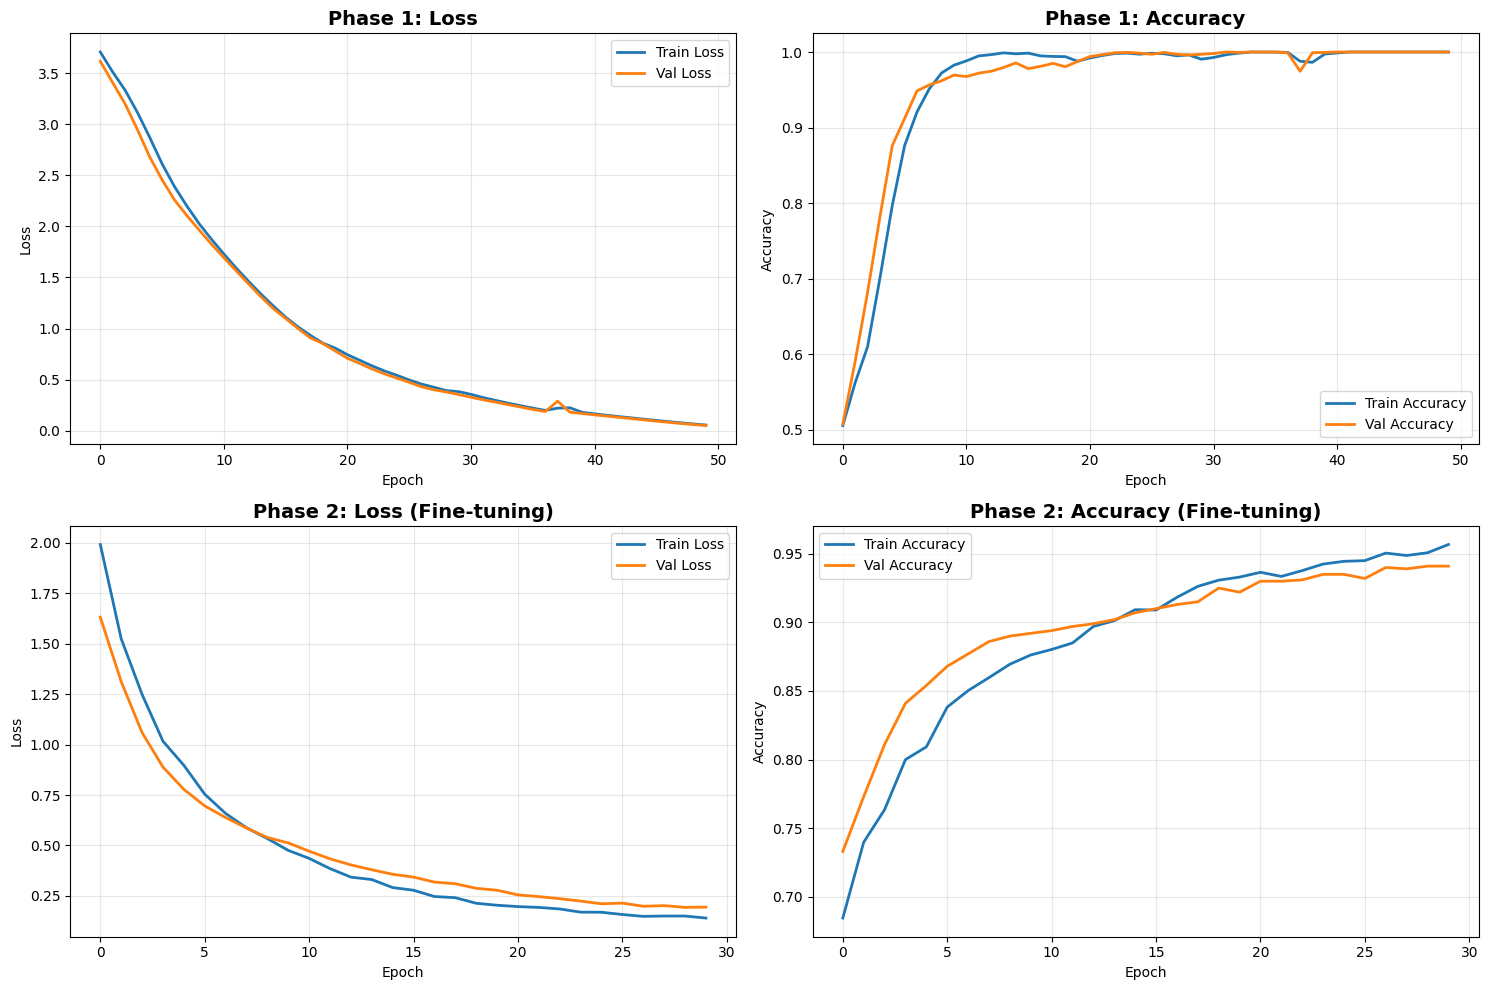

Results summary saved: mobilenetv2_evaluation_results.txt

TRAINING AND EVALUATION COMPLETE!

Generated files:
  Models:
    - mobilenetv2_phase1_best.weights.h5 (best model from phase 1)
    - mobilenetv2_phase1_final.weights.h5 (final model from phase 1)
    - mobilenetv2_phase2_best.weights.h5 (best model from phase 2)
    - mobilenetv2_final_model.weights.h5 (final fine-tuned model)

  Visualizations:
    - mobilenetv2_training_history.png (training curves)
    - mobilenetv2_phase1_base_confusion_matrix.png
    - mobilenetv2_phase1_base_roc_curve.png
    - mobilenetv2_phase2_base_confusion_matrix.png
    - mobilenetv2_phase2_base_roc_curve.png
    - mobilenetv2_phase2_novel_confusion_matrix.png
    - mobilenetv2_phase2_novel_roc_curve.png

  Results:
    - mobilenetv2_evaluation_results.txt (all metrics summary)


In [ ]:
if __name__ == "__main__":
  main()